### imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Load data

In [21]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [22]:
print(f'Train has a shape of {train.shape}')
print(f'Test has a shape of {test.shape}')

Train has a shape of (891, 12)
Test has a shape of (418, 11)


# Preprocessing

## Duplicates

In [23]:
print(f'There are {train.duplicated().sum()} duplicates in the train set.')
print(f'There are {test.duplicated().sum()} duplicates in the test set.')

There are 0 duplicates in the train set.
There are 0 duplicates in the test set.


## Null values

In [24]:
train.isnull().sum(), test.isnull().sum()

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64)

### Drop 'Cabin' column

In [25]:
print(f'There are {train.Cabin.value_counts().sum()} different values for the "Cabin" class in the train set. It can be discarded')
print(f'There are {test.Cabin.value_counts().sum()} different values for the "Cabin" class in the test set. It can be discarded')
train = train.drop(columns='Cabin')
test = test.drop(columns='Cabin')

There are 204 different values for the "Cabin" class in the train set. It can be discarded
There are 91 different values for the "Cabin" class in the test set. It can be discarded


### Filling "Embarked" column with mode

In [26]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [27]:
most_common_embarked = dataset['Embarked'].mode()[0]
display(most_common_embarked)
train.fillna({'Embarked': most_common_embarked}, inplace=True)
test.fillna({'Embarked': most_common_embarked}, inplace=True)
print(f'There are {train.isnull().sum().Embarked} missing values in the "Embarked" column in the train set.')
print(f'There are {test.isnull().sum().Embarked} missing values in the "Embarked" column in the test set.')

'S'

There are 0 missing values in the "Embarked" column in the train set.
There are 0 missing values in the "Embarked" column in the test set.


#### Fill in missing ages by Embarked, Sex and Pclass

In [28]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [29]:
median_age_by_features = dataset.groupby(['Embarked', 'Sex', 'Pclass'])['Age'].median()
median_age_by_features

Embarked  Sex     Pclass
C         female  1         38.00
                  2         23.00
                  3         15.00
          male    1         39.00
                  2         29.00
                  3         24.25
Q         female  1         35.00
                  2         30.00
                  3         22.00
          male    1         44.00
                  2         59.00
                  3         25.00
S         female  1         35.00
                  2         28.00
                  3         22.00
          male    1         42.00
                  2         29.00
                  3         25.00
Name: Age, dtype: float64

In [30]:
def fill_missing_age(row):
    return median_age_by_features.loc[row['Embarked'], row['Sex'], row['Pclass']]

missing_age_mask_train = train['Age'].isnull()
missing_age_mask_test = test['Age'].isnull()

train.loc[missing_age_mask_train, 'Age'] = train[missing_age_mask_train].apply(fill_missing_age, axis=1)
test.loc[missing_age_mask_test, 'Age'] = test[missing_age_mask_test].apply(fill_missing_age, axis=1)

train.Age.isnull().sum(), test.Age.isnull().sum()

(0, 0)

## Remove Name and Ticket from X

In [31]:
train = train.drop(columns=['Name', 'Ticket'])
test = test.drop(columns=['Name', 'Ticket'])

## Join Train and Test

In [32]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [33]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,22.0,1,0,7.2500,S
1,2,1.0,1,female,38.0,1,0,71.2833,C
2,3,1.0,3,female,26.0,0,0,7.9250,S
3,4,1.0,1,female,35.0,1,0,53.1000,S
4,5,0.0,3,male,35.0,0,0,8.0500,S


### Encode Sex Column

In [34]:
enc = OneHotEncoder(handle_unknown='ignore')

encoded_sex = enc.fit_transform(dataset[['Sex']]).toarray()

encoded_sex_df = pd.DataFrame(encoded_sex, columns=enc.get_feature_names_out(['Sex']))

# Concatenate the encoded column with the original DataFrame
dataset = pd.concat([dataset.drop(['Sex'], axis=1), encoded_sex_df], axis=1)

dataset.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,1,0.0,3,22.0,1,0,7.2500,S,0.0,1.0
1,2,1.0,1,38.0,1,0,71.2833,C,1.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,S,1.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,S,1.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,S,0.0,1.0


### Encode Embarked Column

In [35]:
le = LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

# C = 0
# Q = 1
# S = 2


dataset.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,1,0.0,3,22.0,1,0,7.2500,2,0.0,1.0
1,2,1.0,1,38.0,1,0,71.2833,0,1.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,2,1.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,2,1.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,2,0.0,1.0


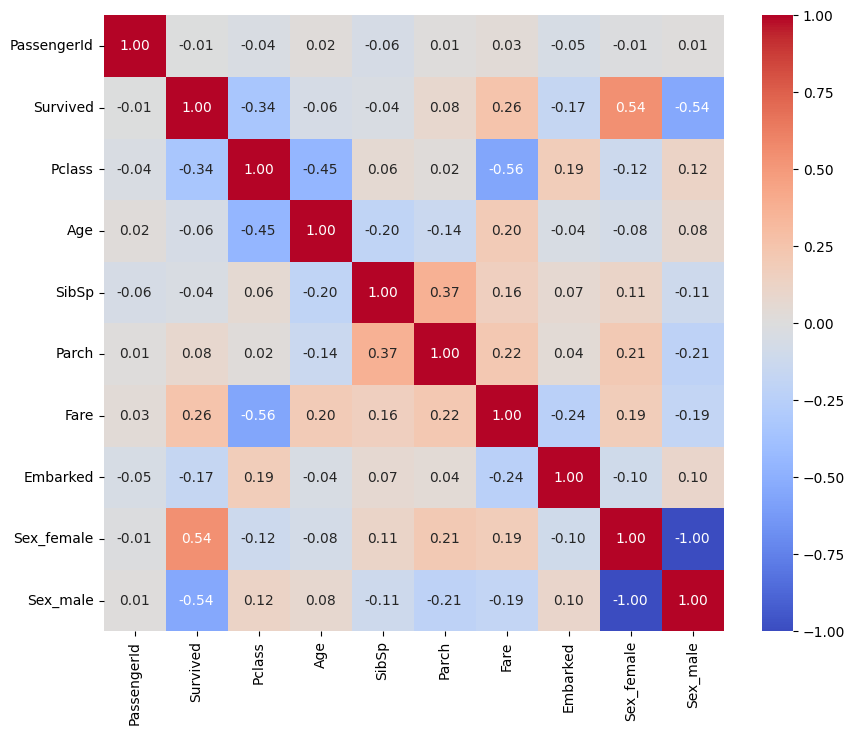

In [36]:
numerical_features = dataset.select_dtypes(include=['number'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [37]:
train = dataset[:train_len]
test = dataset[train_len:]

test.drop(labels=["Survived"],axis = 1,inplace=True)

train.shape, test.shape

/tmp/ipykernel_206230/2341798065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


((891, 10), (418, 9))

In [38]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,1,0.0,3,22.0,1,0,7.2500,2,0.0,1.0
1,2,1.0,1,38.0,1,0,71.2833,0,1.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,2,1.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,2,1.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,2,0.0,1.0


In [39]:
train.to_csv('data/preproc_data/train_1.csv')
test.to_csv('data/preproc_data/test_1.csv')